# Betweeness Centrality

LAGraph_bc: Brandes' algorithm for computing betweeness centrality.
Contributed by Scott Kolodziej and Tim Davis, Texas A&M University.
Adapted from GraphBLAS C API Spec, Appendix B.3.



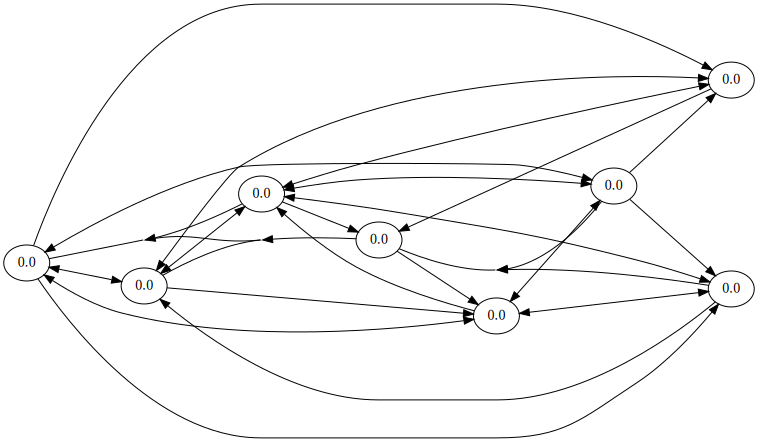

In [1]:
from pygraphblas import *
from pygraphblas.demo.gviz import draw

def bc(A, source):
    n = A.nrows
    centrality = Vector.dense(FP64, n, 0)
    S = Matrix.sparse(INT8, n, n)
    frontier = Vector.sparse(INT8, n)
    frontier[source] = 1
    paths = Vector.dup(frontier)
    depth = 0
    sum = 0
    while True:
        S[:,depth] = frontier
        frontier = frontier.vxm(A, mask=paths, desc=descriptor.oocr)
        paths = paths + frontier
        if frontier.reduce_int() == 0:
            break
        depth += 1
    for i in range(depth, 1, -1):
        centrality += S.transpose()[i-1,:] * ((A @ Vector.dense(INT8, n)) + (centrality / S.transpose()[i,:]))
    return centrality

M = Matrix.random(INT8, 8, 8, 64, no_diagonal=True, make_pattern=True, seed=42)
draw(M, label_vector=bc(M, 2), show_weight=False)

# Betweeness Centraility from GAP Benchmarks


LAGraph_bc_batch: Batch algorithm for computing betweeness centrality.
Contributed by Scott Kolodziej and Tim Davis, Texas A&M University.
Adapted from GraphBLAS C API Spec, Appendix B.4.

LAGraph_bc_batch computes an approximation of the betweenness centrality of
all nodes in a graph using a batched version of Brandes' algorithm.

```
                              ____
                              \      sigma(s,t | i)
   Betweenness centrality =    \    ----------------
          of node i            /       sigma(s,t)
                              /___
                            s ≠ i ≠ t
```
Where sigma(s,t) is the total number of shortest paths from node s to
node t, and sigma(s,t | i) is the total number of shortest paths from
node s to node t that pass through node i.

Note that the true betweenness centrality requires computing shortest paths
from all nodes s to all nodes t (or all-pairs shortest paths), which can be
expensive to compute. By using a reasonably sized subset of source nodes, an
approximation can be made.

LAGraph_bc_batch performs simultaneous breadth-first searches of the entire
graph starting at a given set of source nodes. This pass discovers all
shortest paths from the source nodes to all other nodes in the graph. After
the BFS is complete, the number of shortest paths that pass through a given
node is tallied by reversing the traversal. From this, the (approximate)
betweenness centrality is computed.

A represents the graph, and AT must equal A'.  A must be square, and can be
unsymmetric.  Self-edges are OK.  The values of A and AT are ignored; just
the pattern of two matrices are used.  For best performance, A and AT should
be in their default format (by row); in this case, both phases use a "push"
direction (a saxpy-based multiply) in SuiteSparse:GraphBLAS.


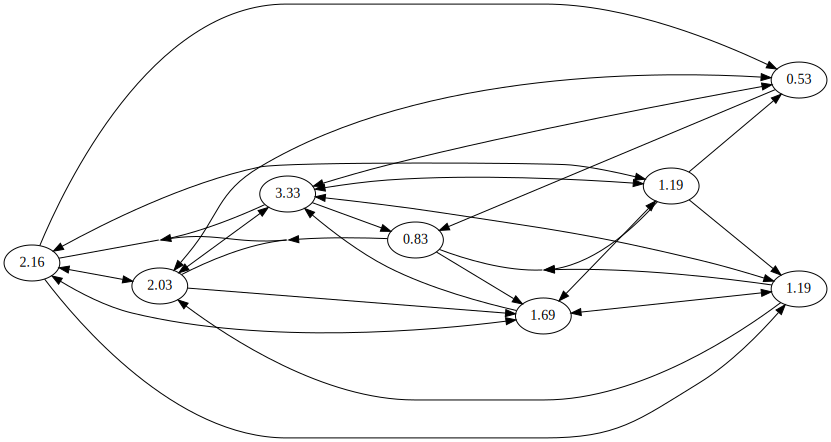

In [4]:
def bc_batch4(A, AT, sources):
    n = A.nrows
    ns = len(sources)
    centrality = Vector.dense (FP32, n, 0)
    paths      = Matrix.dense (FP32, ns, n, 0)
    frontier   = Matrix.sparse(FP32, ns, n)
    S = []
    
    for i, s in enumerate(sources):
        paths[   i, sources[i]] = 1
        frontier[i, sources[i]] = 1

    frontier.mxm(
        A, 
        out=frontier, 
        mask=paths, 
        semiring=FP32.PLUS_FIRST, 
        desc=descriptor.oocr)
    
    for depth in range(n):
        if frontier.nvals == 0:
            break
        s = Matrix.sparse(BOOL, ns, n)
        frontier.apply(BOOL.ONE, out=s)
        S.append(s)

        with Accum(FP32.PLUS):
            paths[:,:] = frontier

        frontier.mxm(
            A, 
            out=frontier, 
            mask=paths, 
            semiring=FP32.PLUS_FIRST, 
            desc=descriptor.oocr)
      
    bc_update = Matrix.dense(FP32, ns, n, 1)
    W = Matrix.sparse(FP32, ns, n)
    
    for i in range(depth -1, 0, -1):
        bc_update.emult(paths, FP32.DIV, out=W, mask=S[i], desc=Replace)
        W.mxm(AT, out=W, mask=S[i-1], semiring=FP32.PLUS_FIRST, desc=Replace)
        W.emult(paths, FP32.TIMES, accum=FP32.PLUS, out=bc_update)
    
    centrality[:] = -ns
    bc_update.reduce_vector(accum=FP32.PLUS, out=centrality, desc=TransposeA)
    
    return centrality

M = Matrix.random(INT64, 8, 8, 64, no_diagonal=True, make_pattern=True, seed=42)
draw(M, label_vector=bc_batch4(M, M.transpose(), [0,2,4,6]), label_width=4, show_weight=False)